In [1]:
pip install matplotlib networkx pandas scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load data from 'pcm-dpc/COVID-19 Italia' GitHub repository

In [3]:
with open('./dati-json/dpc-covid19-ita-province.json') as f:
    covid19_provinces_data = json.load(f)

with open('./dati-json/dpc-covid19-ita-regioni.json') as f:
    covid19_regions_data = json.load(f)

# Provinces's analysis
Here we start grouping the information by provinces

In [4]:
data = []
for province in covid19_provinces_data:
    province_denomination = province['sigla_provincia']
    province_date = province['data']
    # Es. ('FI', '2020-02-24T...', all data on that row)
    # the first 2 values will be used as key
    data.append([province_denomination, province_date, province.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
province_info = []
for province in data:
    index.append([province[0], province[1]]) # (Name, date)
    province_info.append(province[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
data = pd.DataFrame(province_info, index=index, columns=covid19_provinces_data[0].keys())
# and drop some usless columns
density_data = data.drop(columns=['data', 'codice_regione', 'denominazione_regione', 'stato', 'codice_provincia', 'sigla_provincia', 'note_it', 'note_en'])
density_data = density_data[density_data.denominazione_provincia != "In fase di definizione/aggiornamento"]
dati = density_data.drop(columns=['long', 'lat'])
density_data.head()

denominazione_provincia        lat       long  \
AG 2020-02-24T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-25T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-26T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-27T18:00:00               Agrigento  37.309711  13.584575   
   2020-02-28T18:00:00               Agrigento  37.309711  13.584575   

                        totale_casi  
AG 2020-02-24T18:00:00            0  
   2020-02-25T18:00:00            0  
   2020-02-26T18:00:00            0  
   2020-02-27T18:00:00            0  
   2020-02-28T18:00:00            0

## Qua dovrebbero esserci 3 immagini che fanno vedere come cambia l'intensità dei punti nei 3 mesi (per ora ci sono solo i dati dell'ultimo mese)

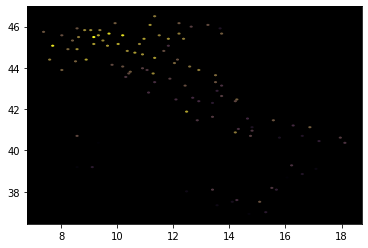

In [5]:
from matplotlib.colors import LinearSegmentedColormap

tmp = []
for i in density_data.index.unique(level=0):
    tmp.append(density_data.loc[i].iloc[-1])
df = pd.DataFrame(tmp)
x = df['long']
y = df['lat']
z = df['totale_casi']

red = ((0., 0., 0.),
         (.3, .5, 0.5),
         (1., 1., 1.))
blue = ((0., .2, .2),
         (.3, .5, .5),
         (.8, .2, .2),
         (1., .1, .1))
green = ((0,1,0),(1,1,0))


cdict3 = {'red':  red,
     'green': green,
     'blue': blue,
     'alpha': ((0.0, 0.0, 0.0),
               (0.3, 0.5, 0.5),
               (1.0, 1.0, 1.0))
    }

dropout_high = LinearSegmentedColormap('Dropout', cdict3)
plt.register_cmap(cmap = dropout_high)

ax = plt.gca()
ax.set_facecolor('black')

plt.hexbin(x,y, C=z, bins='log', cmap=dropout_high, edgecolors=None)

### We extract the total number of cases at the end of the month for each province

In [6]:
# Get the provinces name (Sigle)
provinces = dati.index.unique(level=0)
# Create a DataFrame with total cases per month for each province
cases_per_month = {}

for province in provinces: 
    province_info = dati.loc[province]
    # The 'groupby(province_info.data.str[:7]' is used to group the rows according to the month
    # The [:7] is used to slice the first 7 letters of the 'data' column
    # 2020-05-15T17:00:00 ---> 2020-05
    # And finally sum the 'totale_casi' values grouped by month for each province
    cases_per_month[province] = pd.Series(province_info.groupby(province_info.index.str[:7])['totale_casi'].tail(1))

# Create the DataFrame using the Series defined in the for loop
cpm = pd.DataFrame(cases_per_month)
cpm = cpm.T # For a better view
cpm = cpm.drop(cpm.index[0]) # Drop data without 'denominazione_provincia' info
cpm.columns = [i[0:7] for i in cpm.columns] # Rename the columns dropping away the year
cpm = cpm.drop(columns=['2020-02'])
cpm

,2020-03,2020-04,2020-05
AL,1317,3417,3807
AN,1116,1810,1860
AO,628,1128,1175
AP,222,281,290
AQ,123,243,246
...,...,...,...
VE,1170,2438,2636
VI,1242,2644,2824
VR,2112,4666,5040
VT,181,390,421


### Make a plot for the cities with the highest cases (se metto i bar plot insieme ai pie plot esplodono i grafici, non so perchè, devo ancora rivedere questo punto)

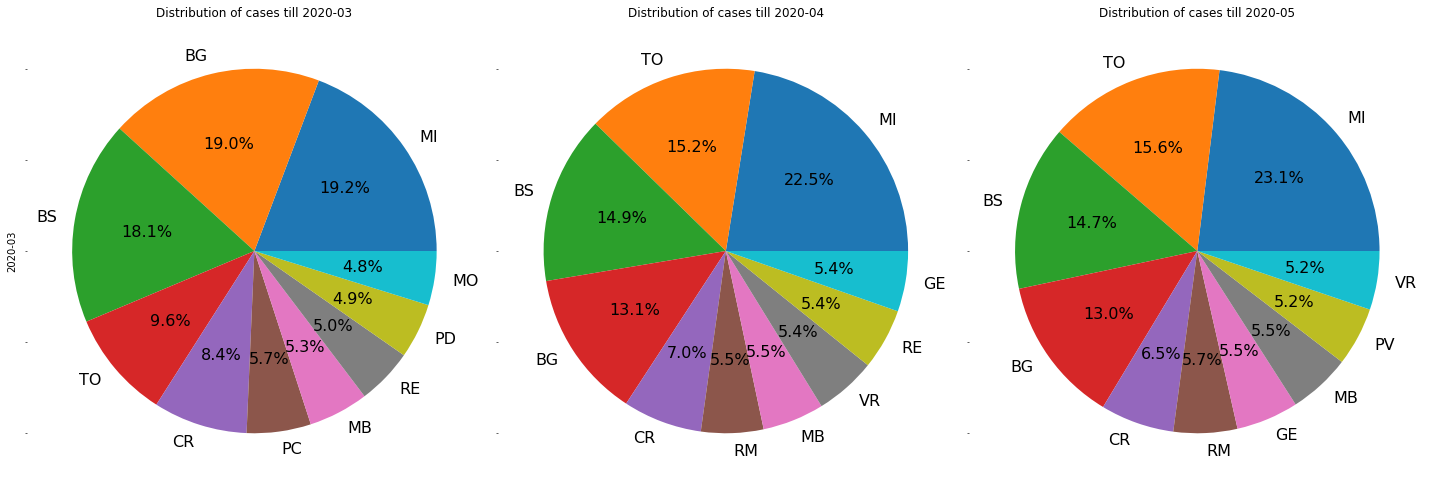

In [7]:
grid_size = (1,3) # For the 4 month considered
colors = ['g', 'r', 'b', 'y']
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharey=True, figsize=(20,20))
cities_with_worst_cases = [] # Store the name of the cities with the worst cases

month = 0
w_cases_pm = [] # worst cases per month -> it will be used for the 'Total number of cases' plot
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        # Cities twith the worst cases in the current month
        worst_cases = cpm.nlargest(10, cpm.columns[month])[cpm.columns[month]] # Top 10
        w_cases_pm.append(worst_cases)
        worst_cases.plot(ax=axes[month], kind="pie", 
                         autopct='%1.1f%%',
                         legend=False,
                         fontsize=16)
        axes[month].set_title('Distribution of cases till '+cpm.columns[month])
        cities_with_worst_cases.append(worst_cases)
        month += 1
        
fig.tight_layout()

### Total cases day by day for cities with the highest cases

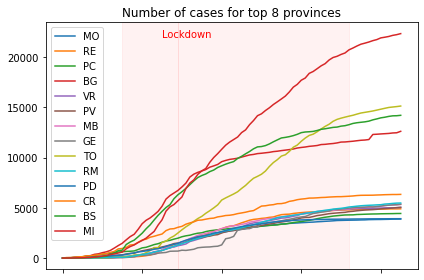

In [8]:
# Create a set of the cities with the highest cases 
interested_city = list(set([item for sublist in [list(city.index) for city in cities_with_worst_cases] for item in sublist]))


# Collect information about these cities day by day
for i in range(len(interested_city)):
    dati.loc[interested_city[i]]['totale_casi'].plot(
        kind='line', 
        label=interested_city[i], 
        title="Number of cases for top 8 provinces").set_xticklabels([])    

plt.text(25, 22000, "Lockdown", color="r")
plt.axvspan(15, 29, color='red', alpha=0.05)
plt.axvspan(29, 72, color='red', alpha=0.05)
plt.tight_layout()
plt.legend()

# Regions's analysis

#### First we group the data by the regions

In [9]:
data = []
for region in covid19_regions_data:
    region_denomination = region['denominazione_regione']
    region_date = region['data']
    data.append([region_denomination, region_date, region.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
region_info = []
for region in data:
    index.append([region[0], region[1]]) # (Name, date)
    region_info.append(region[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
regions_data_frame = pd.DataFrame(region_info, index=index, columns=covid19_regions_data[0].keys()).fillna(0)
regions_data_frame = regions_data_frame.drop(columns=['data', 'codice_regione', 'denominazione_regione', 'stato', 'note_it', 'note_en', 'lat', 'long'])
regions_data_frame.tail()

ricoverati_con_sintomi  terapia_intensiva  \
Veneto 2020-05-15T17:00:00                     311                 24   
       2020-05-16T17:00:00                     290                 20   
       2020-05-17T17:00:00                     273                 22   
       2020-05-18T17:00:00                     263                 22   
       2020-05-19T17:00:00                     259                 18   

                            totale_ospedalizzati  isolamento_domiciliare  \
Veneto 2020-05-15T17:00:00                   335                    4104   
       2020-05-16T17:00:00                   310                    3852   
       2020-05-17T17:00:00                   295                    3746   
       2020-05-18T17:00:00                   285                    3719   
       2020-05-19T17:00:00                   277                    3477   

                            totale_positivi  variazione_totale_positivi  \
Veneto 2020-05-15T17:00:00             4439                        -279   
       2020-05-16T17:00:00             4162                        -277   
       2020-05-17T17:00:00             4041                        -121   
       2020-05-18T17:00:00             4004                         -37   
       2020-05-19T17:00:00             3754                        -250   

                            nuovi_positivi  dimessi_guariti  deceduti  \
Veneto 2020-05-15T17:00:00              44            12688      1762   
       2020-05-16T17:00:00              39            12983      1783   
       2020-05-17T17:00:00              13            13106      1794   
       2020-05-18T17:00:00               9            13143      1803   
       2020-05-19T17:00:00              47            13423      1820   

                            totale_casi  tamponi  casi_testati  
Veneto 2020-05-15T17:00:00        18889   484639      264091.0  
       2020-05-16T17:00:00        18928   497045      269003.0  
       2020-05-17T17:00:00        18941   506588      272938.0  
       2020-05-18T17:00:00        18950   513021      275851.0  
       2020-05-19T17:00:00        18997   523800      280629.0

 #### Then we show all the information for few regions

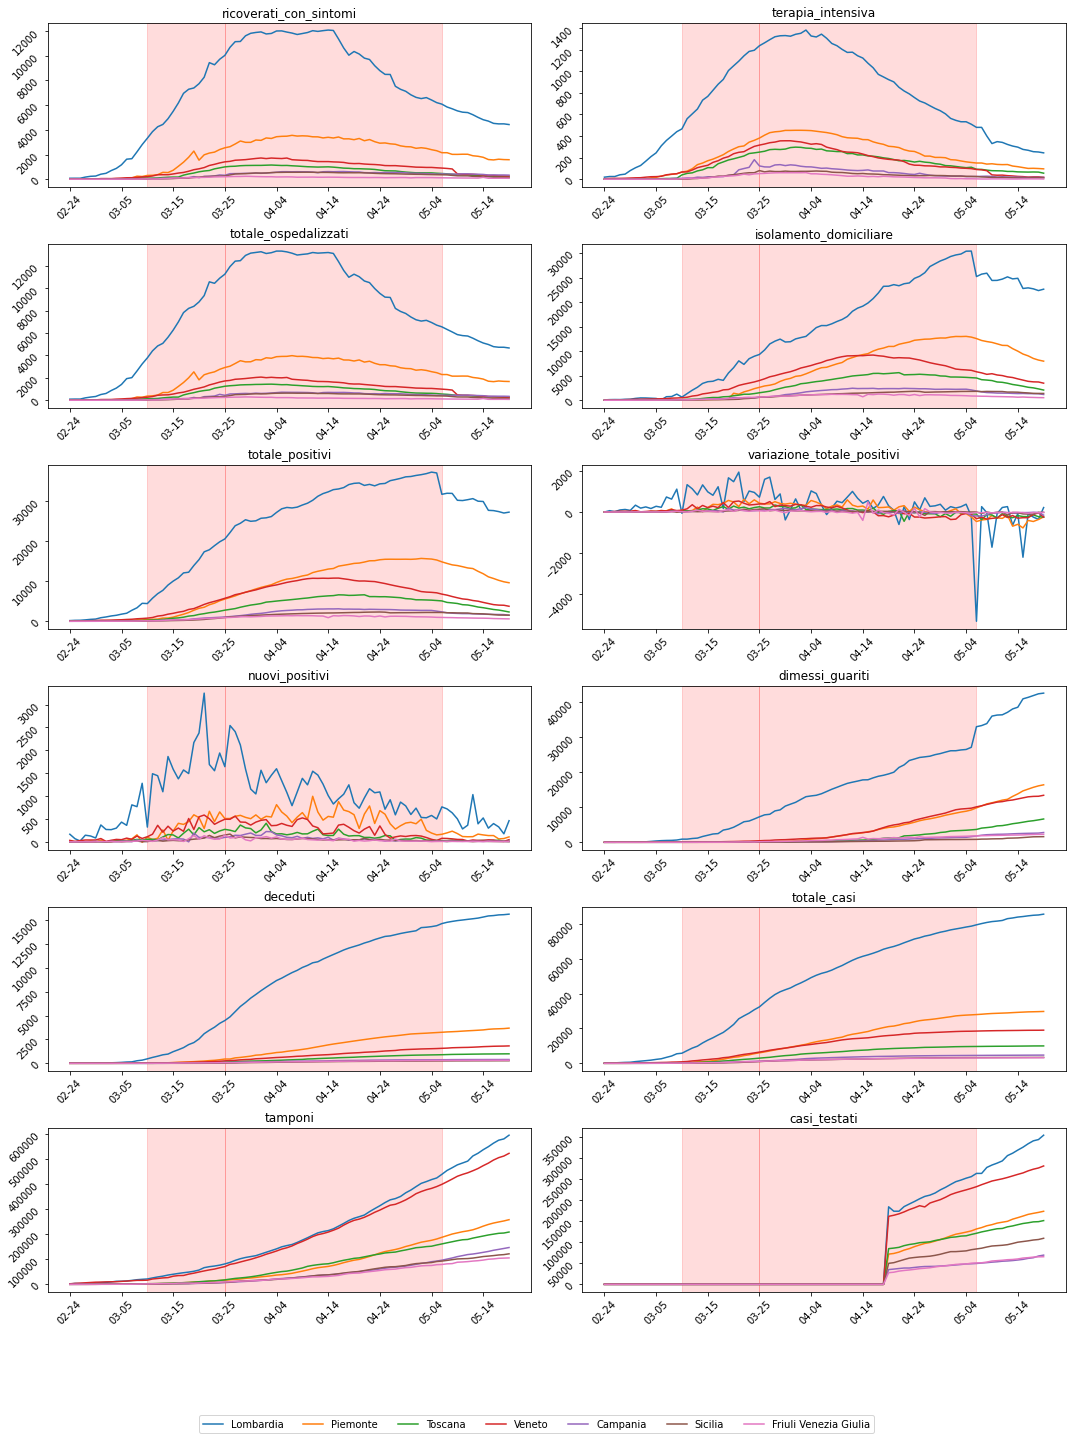

In [10]:
regions_considered = ['Lombardia', 'Piemonte', 'Toscana', 'Veneto', 'Campania', 'Sicilia', 'Friuli Venezia Giulia']
grid_size = (6, 2) # (#regions x #columns's info)
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharex=False, figsize=(15,20))

i = 0
r, c = (0,0)
x_labels = regions_data_frame.index.unique(level=1)
x_labels = [elem[5:10] for elem in x_labels] # take only the month and the day, cut off the rest
for column_info in regions_data_frame.columns:
    for region in regions_considered:
        regions_data_frame.loc[region][column_info].plot(ax=axes[r,c], kind='line', title=column_info)
        axes[r,c].axvspan(15, 30, color='red', alpha=0.02) # Start of lockdown
        axes[r,c].axvspan(30, 72, color='red', alpha=0.02) # Lockdown's effects after 14 days
        # Calculate the xlabels for each subplot
        plt.sca(axes[r, c])
        plt.xticks(range(len(x_labels)), x_labels)
        xticks = axes[r,c].xaxis.get_major_ticks()
        for i in range(len(xticks)):
            if i % 10 != 0:
                xticks[i].set_visible(False)
        axes[r,c].tick_params(labelrotation=45)
        
    # Calculate the next subplot's indexes
    c = (c+1)%grid_size[1]
    if c == 0:
        r+=1
        
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=regions_considered, loc="lower center", ncol=len(regions_considered))